In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## import the library below:

In [2]:
from PyEyeSim import EyeData


In [3]:
%load_ext autoreload
%autoreload 2

## Step 1. 

#### read .csv file containing fixations for all stimuli and participants in a single file with pandas

In [4]:
Path='C:/Users/nickp/Documents/Courses/P1&P2/EyeMovementDat/'
FilePath=Path+'merged_fixations.csv'
FixData=pd.read_csv(FilePath, sep=',',header=0)
print(np.shape(FixData))


(48675, 19)


In [5]:
def downsample_to_60hz(df: pd.DataFrame, original_hz=500, target_hz=60):
    step = round(original_hz / target_hz)
    return df.iloc[::step].reset_index(drop=True)

In [6]:
FixData =  downsample_to_60hz(FixData, original_hz=500, target_hz=60)

## Step 2

#### pass pandas dataframe, to pyeyesim, providing information on screen size in pixels

(we run the pipeline here because this nb is to demonstrate the inference pipeline not the descriptives)


dataset size:  (6085, 19)
presentation size:  x= 1680 pixels y= 1050  pixels
presentation size:  x= 1680 pixels y= 1050  pixels
Stimulus  not found !!, provide column as Stimulus =YourColumn , default:  Stimulus
subjectID  not found !!, provide column as subjectID =YourColumn , default:  subjectID
mean_x  not found !!, provide column as mean_x =YourColumn , default:  mean_x
mean_y  not found !!, provide column as mean_y =YourColumn , default:  mean_y
info found for 70 subjects, and 3 stimuli
sizecorrect =  True ; If stimulus not full screen, assume central presentation, use correction
s7_stimuli_t1.jpg
stimulus size in y is full screen
stimulus size in x full screen
 
s7_stimuli_t4.jpg
stimulus size in y is full screen
stimulus size in x full screen
 
s7_stimuli_t5.jpg
stimulus size in y is full screen
stimulus size in x full screen
 
stimuli loaded succesfully, access as self.images
run descriptive analysis
Data for  70 observers and  3  stimuli.
Mean fixation number:  28.98  +/-  8.0

(array(['s7_stimuli_t1.jpg', 's7_stimuli_t4.jpg', 's7_stimuli_t5.jpg'],
       dtype=object),
 array([1003, 1009, 1016, 1019, 1021, 1033, 1038, 1040, 1058, 1065, 1073,
        1075, 1082, 1090, 1095, 1109, 1113, 1115, 1134, 1145, 1160, 1166,
        1169, 1174, 1186, 1187, 1189, 1209, 1235, 1254, 1255, 1257, 1258,
        1263, 1271, 1274, 1284, 1300, 1312, 1314, 1318, 1322, 1345, 1349,
        1350, 1377, 1380, 1398, 1405, 1417, 1421, 1459, 1476, 1571, 1582,
        1591, 1626, 1693, 1729, 1744, 1760, 1858, 1859, 1869, 1879, 1903,
        1913, 1929, 1993, 1996], dtype=int64))

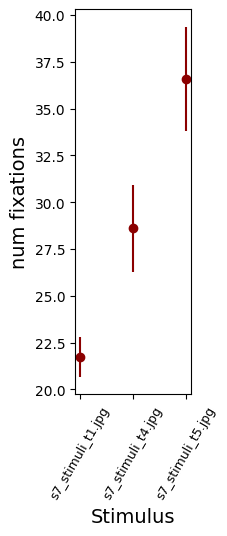

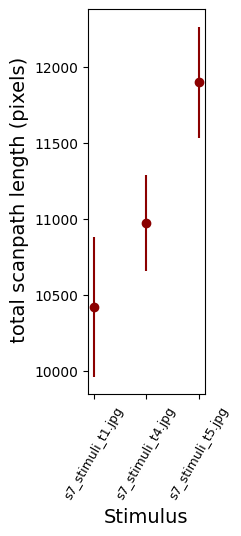

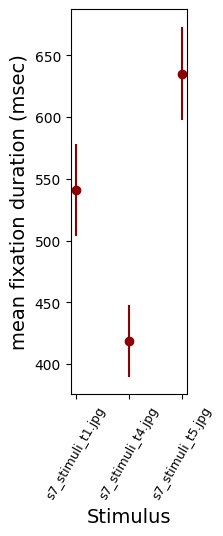

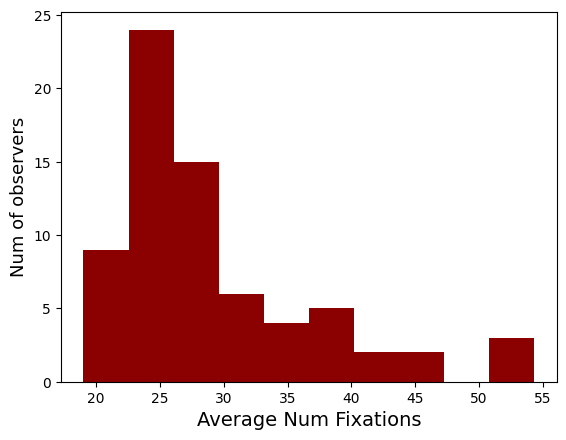

In [7]:

sizeX,sizeY=1680,1050


DyslexiaDat=EyeData(FixData,sizeX,sizeY)
DyslexiaDat.DataInfo(mean_x='orig_fix_x',mean_y='orig_fix_y',FixDuration='duration_ms',Stimulus='stimfile',subjectID='sid', StimPath=Path+'images/',StimExt='.jpg')
DyslexiaDat.RunDescriptiveFix(Visual=1, duration=1)


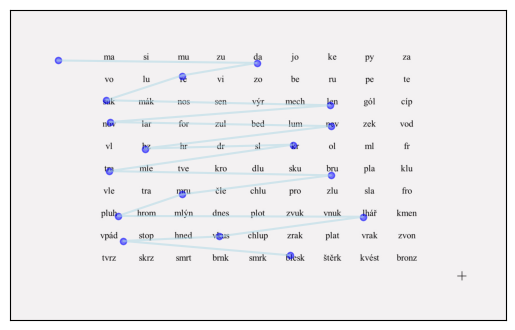

In [17]:
DyslexiaDat.VisScanPath(0,visFix=True,scan_path_col='lightblue', allS=0)

In [8]:
_,WhichCN=DyslexiaDat.GetGroups('class_id')
WhichCN

Conditions [0 1]


array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=object)

In [9]:
from scipy.stats import entropy
def get_entropy(self, subj, stim):
    # get fixation (array([x]), array([y]))
    fixations = DyslexiaDat.GetFixationData(DyslexiaDat.subjects[subj], DyslexiaDat.stimuli[stim])
    # calculate entropy of the fixation distribution
    sizeX = self.x_size
    sizeY = self.y_size
    x = fixations[0].tolist()
    y = fixations[1].tolist()
    # create a 2D histogram
    H, xedges, yedges = np.histogram2d(x, y, bins=(sizeX, sizeY))
    # normalize the histogram
    H = H / H.sum()
    # calculate entropy
    ent = entropy(H.flatten())
    return ent

In [10]:
def GlobalFeature(self, stim):
    Features = np.empty((self.ns), dtype=object)
    for s in range(self.ns):
        angles = []
        progressive_s = 0
        regressive_s = 0
        for saccade in self.GetSaccades()[s][stim]:
            angles.append(saccade.Angle())
            if saccade.Angle() > 270 or saccade.Angle() < 90:
                progressive_s += 1
            elif saccade.Angle() > 90 and saccade.Angle() < 270:
                regressive_s += 1
        
        fix_durations = DyslexiaDat.GetDurations(DyslexiaDat.subjects[s], DyslexiaDat.stimuli[stim])

        Features[s] = {'number_fixation':  self.nfixations[s][stim],
                       'fixation_entropy': get_entropy(self, s, stim),
                       'mean_fixation_duration': np.mean(fix_durations),
                       'std_fixation_duration': np.std(fix_durations),
                       'total_reading_duration': np.sum(fix_durations),
                       'mean_saccade_amplitude': np.mean(angles),
                       'std_saccade_amplitude': np.std(angles),
                       'regression': regressive_s,
                       'progression/regression': progressive_s if regressive_s == 0 else progressive_s/regressive_s
                        }
    return Features  

In [11]:
GlobalFeature_array = GlobalFeature(DyslexiaDat, 0)

In [12]:
from sklearn.preprocessing import StandardScaler

def vectorize(SimAndFeatureVals, subjects):
    FeatureVals, _ = SimAndFeatureVals
    vector_roi = np.zeros((len(FeatureVals), 406))
    for subj, subj_id in enumerate(subjects):
        for v in range(10):
            for h in range(10):
                # FeatureVals[subject][vertical][horizontal] contains 4 features values
                vector_roi[subj][v*40+h*4 : v*40+h*4+4] = np.array(FeatureVals[subj][v][h])
        # add general features
        Features = GlobalFeature_array[subj_id]
        vector_roi[subj][400] = Features['number_fixation']
        vector_roi[subj][401] = Features['mean_fixation_duration']
        vector_roi[subj][402] = Features['total_reading_duration']
        vector_roi[subj][403] = Features['mean_saccade_amplitude']
        vector_roi[subj][404] = Features['regression']
        vector_roi[subj][405] = Features['progression/regression']
    # apply standardization
    scaler = StandardScaler()
    vector_roi = scaler.fit_transform(vector_roi)
    return vector_roi

In [13]:
from sklearn.preprocessing import StandardScaler

def vectorize(SimAndFeatureVals):
    _, SimsVals = SimAndFeatureVals
    vector_roi = np.zeros((len(SimsVals), 4))
    for subj in range(len(SimsVals)):
        vector_roi[subj][0] = SimsVals[subj][0][0][0]
        vector_roi[subj][1] = SimsVals[subj][0][0][1]
        vector_roi[subj][2] = SimsVals[subj][0][0][2]
        vector_roi[subj][3] = SimsVals[subj][0][0][3]
    # apply standardization
    scaler = StandardScaler()
    vector_roi = scaler.fit_transform(vector_roi)
    return vector_roi

In [ ]:
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.utils import io
import numpy as np
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)

# Define the neural network
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(4, 2)
        self.softmax = nn.Softmax(dim=1)
        
        # Initialize weights using Xavier uniform
        nn.init.xavier_uniform_(self.fc1.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.softmax(x)
        return x
    
accuracy = []
conf_matrix = np.zeros((2, 2))

tot_subj = DyslexiaDat.ns
labels = np.array([WhichCN[sub] for sub in range(tot_subj)])

# Stratified 5-Fold cross-validation to maintain label distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for train_index, test_index in skf.split(np.zeros(tot_subj), labels):
    best_loss = np.inf
    train_subj = train_index
    test_subj = test_index

    # Train set
    with io.capture_output() as _:
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(train_subj), nHor=1, nVer=1, nHor_f=2, nVer_f=2, inferS=False, method='peak180', nosubj=list(test_subj)) #  0.6714 
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(train_subj), nHor=1, nVer=1, nHor_f=2, nVer_f=2, inferS=False, method='peak180', match=True, nosubj=list(test_subj)) #0.67
        SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(0, WhichCN, subjects=list(train_subj), nHor=1, nVer=1, nHor_f=2, nVer_f=2, inferS=False, method='cosine', Thr=10, nosubj=list(test_subj)) #0.47
    vector_roi = vectorize(SimAndFeatureVals)
    labels_train = np.array([WhichCN[sub] for sub in train_subj])

    # Train set
    X_train = torch.tensor(vector_roi, dtype=torch.float32).to(device)
    y_train = torch.tensor(labels_train, dtype=torch.long).to(device) 

    # Test set
    with io.capture_output() as _:
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=2, nVer_f=2, inferS=False, method='peak180')
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=2, nVer_f=2, inferS=False, method='peak180', match=True) 
        SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(0, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=2, nVer_f=2, inferS=False, method='cosine', Thr=10) 
    vector_roi = vectorize(SimAndFeatureVals)
    labels_test = np.array([WhichCN[sub] for sub in test_subj])

    # Test set
    X_test = torch.tensor(vector_roi, dtype=torch.float32).to(device)
    y_test = torch.tensor(labels_test, dtype=torch.long).to(device) 

    # Initialize the model, loss function, and optimizer
    model = NN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.5)

    # Train the model
    model.train()
    for epoch in range(20):  # number of epochs
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        # print loss every 5 epochs
        if epoch % 5 == 0:
            print(f'Epoch {epoch} loss: {loss.item()}')

        if loss < best_loss:
            # save checkpoint
            checkpoint = {'model': model, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            best_loss = loss

    # Load the best model
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predictions = torch.argmax(outputs, dim=1)  # Take the class with highest probability
        accuracy.append(accuracy_score(y_test.cpu(), predictions.cpu()))
        conf_matrix += confusion_matrix(y_test.cpu(), predictions.cpu())

# Results
accuracy = np.array(accuracy)
print(f'Average accuracy: {np.mean(accuracy)}')
print(f'Standard deviation: {np.std(accuracy)}')
print(f'Total confusion matrix:\n{conf_matrix}')
print(f'False positives: {conf_matrix[0, 1]}')
print(f'False negatives: {conf_matrix[1, 0]}')

Using device: cuda
Epoch 0 loss: 0.6749250292778015
Epoch 5 loss: 0.6739503741264343
Epoch 10 loss: 0.6728366017341614
Epoch 15 loss: 0.6718032956123352
Epoch 0 loss: 0.7735744714736938
Epoch 5 loss: 0.7659005522727966
Epoch 10 loss: 0.7588819861412048
Epoch 15 loss: 0.751870334148407
Epoch 0 loss: 0.6978591680526733
Epoch 5 loss: 0.6918999552726746
Epoch 10 loss: 0.686097264289856
Epoch 15 loss: 0.6811989545822144
Epoch 0 loss: 0.6853067278862
Epoch 5 loss: 0.6822561621665955
Epoch 10 loss: 0.6791806221008301
Epoch 15 loss: 0.6765913963317871
Epoch 0 loss: 0.7051816582679749
Epoch 5 loss: 0.7022576332092285
Epoch 10 loss: 0.6991572380065918
Epoch 15 loss: 0.6969394683837891
Average accuracy: 0.5285714285714286
Standard deviation: 0.08571428571428573
Total confusion matrix:
[[27.  8.]
 [25. 10.]]
False positives: 8.0
False negatives: 25.0


---

## Test 10 x 10 ROI

In [21]:
from sklearn.preprocessing import StandardScaler

def vectorize(SimAndFeatureVals, subjects):
    vector_roi = np.zeros((len(SimAndFeatureVals), 806))
    for subj, subj_id in enumerate(subjects):
        for v in range(10):
            for h in range(10):
                # SimAndFeatureVals[subject][vertical][horizontal] contains 8 features values
                vector_roi[subj][v*80+h*8 : v*80+h*8+8] = np.array(SimAndFeatureVals[subj][v][h])
        # add general features
        Features = GlobalFeature_array[subj_id]
        vector_roi[subj][800] = Features['number_fixation']
        vector_roi[subj][801] = Features['mean_fixation_duration']
        vector_roi[subj][802] = Features['total_reading_duration']
        vector_roi[subj][803] = Features['mean_saccade_amplitude']
        vector_roi[subj][804] = Features['regression']
        vector_roi[subj][805] = Features['progression/regression']
    # apply standardization
    scaler = StandardScaler()
    vector_roi = scaler.fit_transform(vector_roi)
    return vector_roi

In [ ]:
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.utils import io
import numpy as np
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)

# Define the neural network
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(806, 403)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(403, 201)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(201, 100)
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(100, 50)
        self.dropout4 = nn.Dropout(p=0.2)
        self.fc5 = nn.Linear(50, 2)
        self.softmax = nn.Softmax(dim=1)
        
        # Initialize weights using Xavier uniform
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)
        nn.init.xavier_uniform_(self.fc5.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = torch.relu(self.fc4(x))
        x = self.dropout4(x)
        x = self.softmax(self.fc5(x)) 
        return x

accuracy = []
conf_matrix = np.zeros((2, 2))

tot_subj = DyslexiaDat.ns
labels = np.array([WhichCN[sub] for sub in range(tot_subj)])

# Stratified 5-Fold cross-validation to maintain label distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for train_index, test_index in skf.split(np.zeros(tot_subj), labels):
    best_loss = np.inf
    train_subj = train_index
    test_subj = test_index

    # Train set
    with io.capture_output() as _:
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(train_subj), nHor=10, nVer=10, inferS=False, Thr=10, method='cosine', nosubj=list(test_subj)) # 0.81 0.11
        SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(train_subj), nHor=10, nVer=10, inferS=False, method='peak180', nosubj=list(test_subj)) # 0.75 0.18
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(train_subj), nHor=10, nVer=10, inferS=False, method='peak180', match=True, nosubj=list(test_subj)) # 0.77 0.13
    vector_roi = vectorize(SimAndFeatureVals , train_subj)
    labels_train = np.array([WhichCN[sub] for sub in train_subj])

    # Train set
    X_train = torch.tensor(vector_roi, dtype=torch.float32).to(device)
    y_train = torch.tensor(labels_train, dtype=torch.long).to(device) 

    # Test set
    with io.capture_output() as _:
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(test_subj), nHor=10, nVer=10, inferS=False, Thr=10, method='cosine')
        SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(test_subj), nHor=10, nVer=10, inferS=False, method='peak180')
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(test_subj), nHor=10, nVer=10, inferS=False, method='peak180', match=True)
    vector_roi = vectorize(SimAndFeatureVals , test_subj)
    labels_test = np.array([WhichCN[sub] for sub in test_subj])

    # Test set
    X_test = torch.tensor(vector_roi, dtype=torch.float32).to(device)
    y_test = torch.tensor(labels_test, dtype=torch.long).to(device) 

    # Initialize the model, loss function, and optimizer
    model = NN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.8)

    # Train the model
    model.train()
    for epoch in range(20):  # number of epochs
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        # print loss every 5 epochs
        if epoch % 5 == 0:
            print(f'Epoch {epoch} loss: {loss.item()}')

        if loss < best_loss:
            # save checkpoint
            checkpoint = {'model': model, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            best_loss = loss

    # Load the best model
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predictions = torch.argmax(outputs, dim=1)  # Take the class with highest probability
        accuracy.append(accuracy_score(y_test.cpu(), predictions.cpu()))
        conf_matrix += confusion_matrix(y_test.cpu(), predictions.cpu())

# Results
accuracy = np.array(accuracy)
print(f'Average accuracy: {np.mean(accuracy)}')
print(f'Standard deviation: {np.std(accuracy)}')
print(f'Total confusion matrix:\n{conf_matrix}')
print(f'False positives: {conf_matrix[0, 1]}')
print(f'False negatives: {conf_matrix[1, 0]}')

Using device: cuda
Epoch 0 loss: 0.7488258481025696
Epoch 5 loss: 0.40441083908081055
Epoch 10 loss: 0.3158758282661438
Epoch 15 loss: 0.31520047783851624
Epoch 0 loss: 0.7477982640266418
Epoch 5 loss: 0.38293027877807617
Epoch 10 loss: 0.3149331510066986
Epoch 15 loss: 0.313275545835495
Epoch 0 loss: 0.7221447825431824
Epoch 5 loss: 0.36577144265174866
Epoch 10 loss: 0.3149000108242035
Epoch 15 loss: 0.31337520480155945
Epoch 0 loss: 0.7023888230323792
Epoch 5 loss: 0.43297913670539856
Epoch 10 loss: 0.32384225726127625
Epoch 15 loss: 0.3136361539363861
Epoch 0 loss: 0.7212005853652954
Epoch 5 loss: 0.500238835811615
Epoch 10 loss: 0.33016568422317505
Epoch 15 loss: 0.3141186833381653
Average accuracy: 0.7571428571428571
Standard deviation: 0.18405855323893036
Total confusion matrix:
[[25. 10.]
 [ 7. 28.]]
False positives: 10.0
False negatives: 7.0


---

## 10 x 10 ROI and Similarity measure applied to the whole image

In [42]:
# this one for all the similarity measure that does not account for the number of fixations
from sklearn.preprocessing import StandardScaler

def vectorize(SimAndFeatureVals, subjects):
    FeatureVals, SimsVals = SimAndFeatureVals
    vector_roi = np.zeros((len(FeatureVals), 408))
    for subj, subj_id in enumerate(subjects):
        for v in range(10):
            for h in range(10):
                # FeatureVals[subject][vertical][horizontal] contains 4 features values
                vector_roi[subj][v*40+h*4 : v*40+h*4+4] = np.array(FeatureVals[subj][v][h])
        # add general features
        Features = GlobalFeature_array[subj_id]
        vector_roi[subj][400] = Features['number_fixation']
        vector_roi[subj][401] = Features['mean_saccade_amplitude']
        vector_roi[subj][402] = Features['mean_fixation_duration']
        vector_roi[subj][403] = Features['total_reading_duration']
        vector_roi[subj][404] = Features['regression']
        vector_roi[subj][405] = Features['progression/regression']
        vector_roi[subj][406] = SimsVals[subj][0][0][0] 
        vector_roi[subj][407] = SimsVals[subj][0][0][1]
        
    # apply standardization
    scaler = StandardScaler()
    vector_roi = scaler.fit_transform(vector_roi)
    return vector_roi

In [ ]:
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.utils import io
import numpy as np
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)

# Define the neural network
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(408, 204)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(204, 102)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(102, 51)
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(51, 2)  
        self.softmax = nn.Softmax(dim=1)
        
        # Initialize weights using Xavier uniform
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.softmax(self.fc4(x)) 
        return x

accuracy = []
conf_matrix = np.zeros((2, 2))

tot_subj = DyslexiaDat.ns
labels = np.array([WhichCN[sub] for sub in range(tot_subj)])

# Stratified 5-Fold cross-validation to maintain label distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for train_index, test_index in skf.split(np.zeros(tot_subj), labels):
    best_loss = np.inf
    train_subj = train_index
    test_subj = test_index

    # Train set
    with io.capture_output() as _:
        SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(train_subj),  nHor=1, nVer=1, nHor_f=10, nVer_f=10, inferS=False,  Thr=10, method='cosine', nosubj=list(test_subj)) # 85.71% +- 5.7
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(train_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=10, inferS=False, method='peak180', nosubj=list(test_subj)) # 0.82 +- 0.13
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(train_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=10, inferS=False, method='peak180', match=True, nosubj=list(test_subj)) # 0.78 0.14
    vector_roi = vectorize(SimAndFeatureVals, train_subj)
    labels_train = np.array([WhichCN[sub] for sub in train_subj])

    # Train set
    X_train = torch.tensor(vector_roi, dtype=torch.float32).to(device)
    y_train = torch.tensor(labels_train, dtype=torch.long).to(device) 

    # Test set
    with io.capture_output() as _:
        SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=10, inferS=False, Thr=10, method='cosine')
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=10, inferS=False, method='peak180')
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(2, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=10, inferS=False, method='peak180', match=True)
    vector_roi = vectorize(SimAndFeatureVals, test_subj)
    labels_test = np.array([WhichCN[sub] for sub in test_subj])

    # Test set
    X_test = torch.tensor(vector_roi, dtype=torch.float32).to(device)
    y_test = torch.tensor(labels_test, dtype=torch.long).to(device) 

    # Initialize the model, loss function, and optimizer
    model = NN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.8)

    # Train the model
    model.train()
    for epoch in range(20):  # number of epochs
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        # print loss every 5 epochs
        if epoch % 5 == 0:
            print(f'Epoch {epoch} loss: {loss.item()}')

        if loss < best_loss:
            # save checkpoint
            checkpoint = {'model': model, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            best_loss = loss

    # Load the best model
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predictions = torch.argmax(outputs, dim=1)  # Take the class with highest probability
        accuracy.append(accuracy_score(y_test.cpu(), predictions.cpu()))
        conf_matrix += confusion_matrix(y_test.cpu(), predictions.cpu())

# Results
accuracy = np.array(accuracy)
print(f'Average accuracy: {np.mean(accuracy)}')
print(f'Standard deviation: {np.std(accuracy)}')
print(f'Total confusion matrix:\n{conf_matrix}')
print(f'False positives: {conf_matrix[0, 1]}')
print(f'False negatives: {conf_matrix[1, 0]}')

In [14]:
# this one for all the similarity measure that does not account for the number of fixations
from sklearn.preprocessing import StandardScaler

def vectorize(SimAndFeatureVals, subjects):
    FeatureVals, SimsVals = SimAndFeatureVals
    vector_roi = np.zeros((len(FeatureVals), 367))
    for subj, subj_id in enumerate(subjects):
        for v in range(9):
            for h in range(10):
                # FeatureVals[subject][vertical][horizontal] contains 4 features values
                vector_roi[subj][v*40+h*4 : v*40+h*4+4] = np.array(FeatureVals[subj][v][h])
        # add general features
        Features = GlobalFeature_array[subj_id]
        vector_roi[subj][360] = Features['number_fixation']
        vector_roi[subj][361] = Features['mean_fixation_duration']
        vector_roi[subj][362] = Features['total_reading_duration']
        vector_roi[subj][363] = Features['regression']
        vector_roi[subj][364] = Features['progression/regression']
        vector_roi[subj][365] = SimsVals[subj][0][0][0] 
        vector_roi[subj][366] = SimsVals[subj][0][0][1]
        
    # apply standardization
    scaler = StandardScaler()
    vector_roi = scaler.fit_transform(vector_roi)
    return vector_roi

In [15]:
import torch
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.utils import io
import numpy as np
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)
np.random.seed(42)

# Define the neural network
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(367, 184)
        self.dropout1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(184, 92)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc3 = nn.Linear(92, 41)
        self.dropout3 = nn.Dropout(p=0.2)
        self.fc4 = nn.Linear(41, 2)  
        self.softmax = nn.Softmax(dim=1)
        
        # Initialize weights using Xavier uniform
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.softmax(self.fc4(x)) 
        return x

accuracy = []
conf_matrix = np.zeros((2, 2))

tot_subj = DyslexiaDat.ns
labels = np.array([WhichCN[sub] for sub in range(tot_subj)])

# Stratified 5-Fold cross-validation to maintain label distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

for train_index, test_index in skf.split(np.zeros(tot_subj), labels):
    best_loss = np.inf
    train_subj = train_index
    test_subj = test_index

    # Train set
    with io.capture_output() as _:
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(0, WhichCN, subjects=list(train_subj),  nHor=1, nVer=1, nHor_f=10, nVer_f=9, inferS=False,  Thr=10, method='cosine', nosubj=list(test_subj)) # 0.9428571428571428 +- 0.02857142857142856
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(0, WhichCN, subjects=list(train_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=9, inferS=False, method='peak180', nosubj=list(test_subj)) # 0.9285714285714286 +- 0.04517539514526258
        SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(0, WhichCN, subjects=list(train_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=9, inferS=False, method='peak180', match=True, nosubj=list(test_subj)) # 0.9142857142857144 +- 0.028571428571428602
    vector_roi = vectorize(SimAndFeatureVals, train_subj)
    labels_train = np.array([WhichCN[sub] for sub in train_subj])

    # Train set
    X_train = torch.tensor(vector_roi, dtype=torch.float32).to(device)
    y_train = torch.tensor(labels_train, dtype=torch.long).to(device) 

    # Test set
    with io.capture_output() as _:
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(0, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=9, inferS=False, Thr=10, method='cosine')
        #SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(0, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=9, inferS=False, method='peak180')
        SimAndFeatureVals = DyslexiaDat.SacSimSubj2GroupPlusFeature(0, WhichCN, subjects=list(test_subj), nHor=1, nVer=1, nHor_f=10, nVer_f=9, inferS=False, match=True, method='peak180')
    vector_roi = vectorize(SimAndFeatureVals, test_subj)
    labels_test = np.array([WhichCN[sub] for sub in test_subj])

    # Test set
    X_test = torch.tensor(vector_roi, dtype=torch.float32).to(device)
    y_test = torch.tensor(labels_test, dtype=torch.long).to(device) 

    # Initialize the model, loss function, and optimizer
    model = NN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.5)

    # Train the model
    model.train()
    for epoch in range(20):  # number of epochs
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        # print loss every 5 epochs
        if epoch % 5 == 0:
            print(f'Epoch {epoch} loss: {loss.item()}')

        if loss < best_loss:
            # save checkpoint
            checkpoint = {'model': model, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
            best_loss = loss

    # Load the best model
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        predictions = torch.argmax(outputs, dim=1)  # Take the class with highest probability
        accuracy.append(accuracy_score(y_test.cpu(), predictions.cpu()))
        conf_matrix += confusion_matrix(y_test.cpu(), predictions.cpu())

# Results
accuracy = np.array(accuracy)
print(f'Average accuracy: {np.mean(accuracy)}')
print(f'Standard deviation: {np.std(accuracy)}')
print(f'Total confusion matrix:\n{conf_matrix}')
print(f'False positives: {conf_matrix[0, 1]}')
print(f'False negatives: {conf_matrix[1, 0]}')

Using device: cuda
Epoch 0 loss: 0.7042060494422913
Epoch 5 loss: 0.5046072006225586
Epoch 10 loss: 0.3895459473133087
Epoch 15 loss: 0.34656742215156555
Epoch 0 loss: 0.714752733707428
Epoch 5 loss: 0.5270069241523743
Epoch 10 loss: 0.40137481689453125
Epoch 15 loss: 0.36220628023147583
Epoch 0 loss: 0.716718316078186
Epoch 5 loss: 0.44988155364990234
Epoch 10 loss: 0.35211506485939026
Epoch 15 loss: 0.33201226592063904
Epoch 0 loss: 0.6999726295471191
Epoch 5 loss: 0.5184006094932556
Epoch 10 loss: 0.3833182156085968
Epoch 15 loss: 0.33105072379112244
Epoch 0 loss: 0.7059570550918579
Epoch 5 loss: 0.5290514826774597
Epoch 10 loss: 0.3910711109638214
Epoch 15 loss: 0.3365615904331207
Average accuracy: 0.7857142857142857
Standard deviation: 0.11952286093343938
Total confusion matrix:
[[27.  8.]
 [ 7. 28.]]
False positives: 8.0
False negatives: 7.0


---

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct
from scipy.fft import fft

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [46]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct, idct
from scipy.fft import fft

def get_data(stim, split_size, batch_size, random_state, addin_features=False):
    # Splitting by participants
    subj = FixData['sid'].unique()
    train_participants, test_participants = train_test_split(subj, test_size=split_size, random_state=random_state)
    Data=FixData[FixData['stimfile']== stim]
    train_data = Data[Data['sid'].isin(train_participants)]
    test_data = Data[Data['sid'].isin(test_participants)]

    # Feature selection for each participant
    def extract_features(data):
        features, labels, handcrafted = [], [], []
        for subj in data['sid'].unique():
            subj_data = data[data['sid'] == subj][['orig_fix_x', 'orig_fix_y']].values
            features.append(subj_data)
            labels.append(data[data['sid'] == subj]['class_id'].iloc[0])

            # Compute handcrafted features
            x, y = subj_data[:, 0], subj_data[:, 1]
            H, _, _ = np.histogram2d(x, y, bins=(1680, 1050))
            H = H / H.sum()
            ent = entropy(H.flatten())

            # Calculate scanpath length
            scanlen = np.sum(np.sqrt(np.diff(x) ** 2 + np.diff(y) ** 2))
            nfix = len(subj_data)

            handcrafted.append([ent, scanlen, nfix])  # Add handcrafted features

        return features, labels, handcrafted

    train_features, train_labels, train_handcrafted = extract_features(train_data)
    test_features, test_labels, test_handcrafted = extract_features(test_data)

    # "Eye tracking based dyslexia detection using a holistic approach"
    # Step 1: Perform DCT Type III (and interpoalte Step 2)
    def perform_dct_interpolate(data, pad_size):
        # sqrt(2/pad_size) * cn * cos((pi * ((2*k + 1) * n)) / (2 * pad_size)) k = 0, 1, ..., pad_size - 1 n = 0, 1, ..., pad_size - 1
        dct_result = np.zeros((pad_size, data.shape[1]))
        for n in range(data.shape[1]):
            for k in range(pad_size):
                cn = np.sqrt(2 / pad_size) if k != 0 else np.sqrt(1 / pad_size)
                dct_result[k, n] = cn * np.sum(data[:, n] * np.cos((np.pi * (2 * np.arange(data.shape[0]) + 1) * k) / (2 * pad_size)))
        return dct_result
        
    # Step 3: Perform IDCT Type III
    def perform_idct(data):
        idct_result = np.zeros((data.shape[0], data.shape[1]))
        for n in range(data.shape[1]):
            for k in range(data.shape[0]):
                idct_result[k, n] = np.sum(data[:, n] * np.cos((np.pi * (2 * np.arange(data.shape[0]) + 1) * k) / (2 * data.shape[0])) * (np.sqrt(2 / data.shape[0]) if k != 0 else np.sqrt(1 / data.shape[0])))
        return idct_result

    # Step 4: Energy correction based on number of zeros
    def correct_energy(data, original_length):
        # Calculate the ratio of the original length to the padded length
        ratio = original_length / data.shape[0]
        return data * ratio

    # Step 5: Perform Discrete Fourier Transform (DFT)
    def perfrom_dft(data):
        return fft(data, axis=0)

    # Step 6: Magnitude calculation
    def calculate_magnitude(data):
        return np.abs(data)

    def data_output(data, pad_size):
        dct_result = perform_dct_interpolate(data, pad_size)
        idct_result = perform_idct(dct_result)
        corrected_data = correct_energy(idct_result, len(data))
        dft_result = perfrom_dft(corrected_data)
        magnitude = calculate_magnitude(dft_result)
        #for the final data we can return just N/2 as the data is symmetric
        final_data = magnitude[:magnitude.shape[0]//2]
        return final_data

    pad = max([len(data) for data in train_features + test_features])
    # Apply the pipeline to all participants
    train_features = [data_output(data, pad) for data in train_features]
    test_features = [data_output(data, pad) for data in test_features]

    # Convert to PyTorch tensors
    train_features = torch.tensor(train_features, dtype=torch.float32)
    test_features = torch.tensor(test_features, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.float32).unsqueeze(1)
    test_labels = torch.tensor(test_labels, dtype=torch.float32).unsqueeze(1)

    if addin_features:
        train_handcrafted = torch.tensor(train_handcrafted, dtype=torch.float32)
        test_handcrafted = torch.tensor(test_handcrafted, dtype=torch.float32)

        train_dataset = TensorDataset(train_features, train_handcrafted, train_labels)
        test_dataset = TensorDataset(test_features, test_handcrafted, test_labels)

    else:
        train_dataset = TensorDataset(train_features, train_labels)
        test_dataset = TensorDataset(test_features, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, test_loader, train_features, train_labels, test_features, test_labels

In [47]:
stimulus = DyslexiaDat.stimuli[2]

C:\Users\nickp\AppData\Local\Temp\ipykernel_1424\3352190650.py:88: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  train_features = torch.tensor(train_features, dtype=torch.float32)


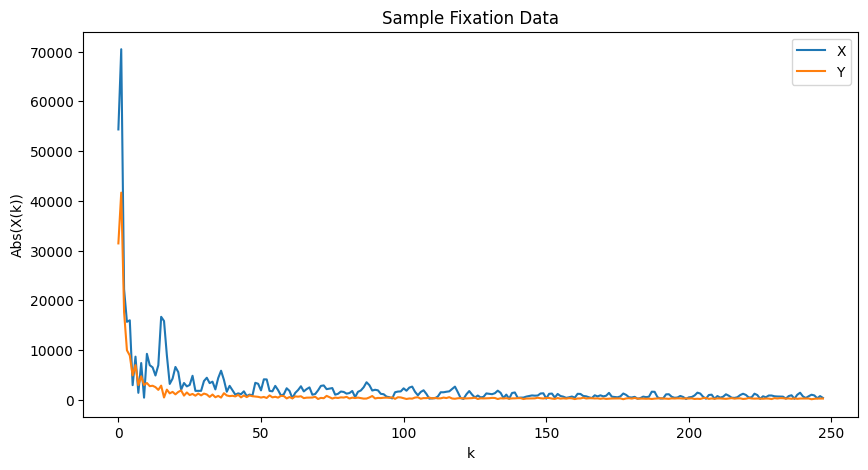

In [48]:
# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Enable verbose mode
verbose = True

# Load data
train_loader, test_loader, train_features, train_labels, test_features, test_labels = get_data(
    stim=stimulus, split_size=0.1, batch_size=32, random_state=42, addin_features=False
)

# train_features = torch.Size([63, 248, 2]) 63 subjects, 248 magnitudes values, 2 channels (x, y)
plt.figure(figsize=(10, 5))
plt.plot(train_features[0, :, 0], label='X')
plt.plot(train_features[0, :, 1], label='Y')
plt.xlabel('k')
plt.ylabel('Abs(X(k))')
plt.title('Sample Fixation Data')
plt.legend()
plt.show()


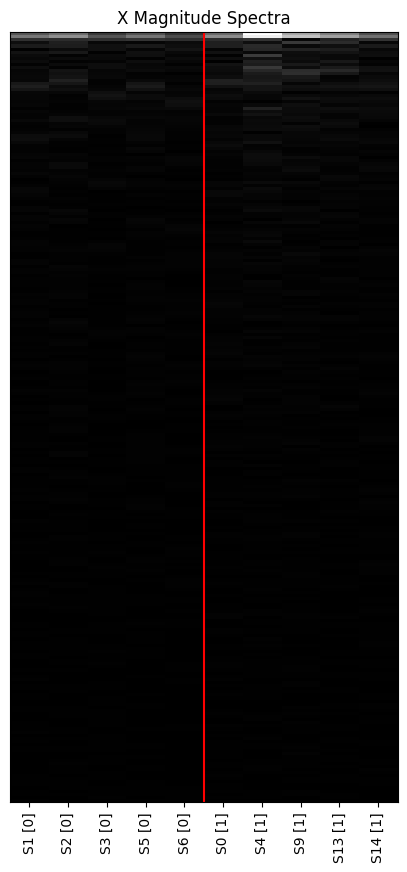

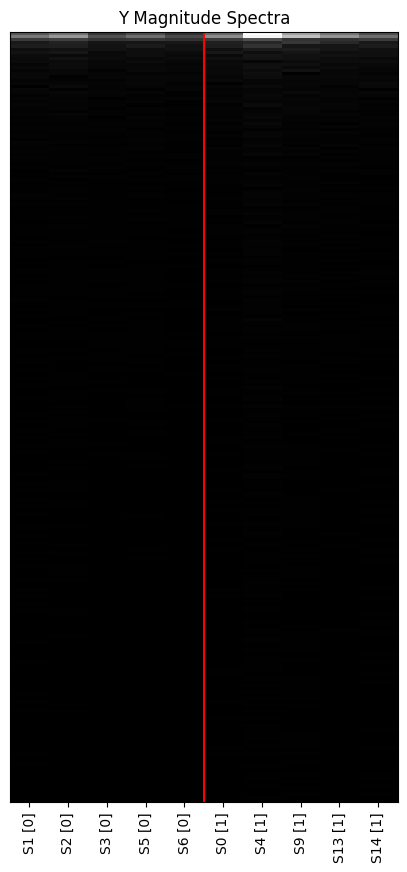

In [ ]:
def plot_group_spectra(features, labels, title, channel):
    """
    Plots magnitude spectra for 5 subjects with label 0 vs. 5 subjects with label 1
    in a vertical grayscale heatmap.
    """
    # Select 5 subjects with label 0 and 5 subjects with label 1
    indices_0 = [i for i in range(len(labels)) if labels[i] == 0][:5]
    indices_1 = [i for i in range(len(labels)) if labels[i] == 1][:5]

    subjects_0 = torch.cat([features[i, :, channel].unsqueeze(1) for i in indices_0], dim=1)
    subjects_1 = torch.cat([features[i, :, channel].unsqueeze(1) for i in indices_1], dim=1)
    
    # Combine both groups into one visualization
    combined = torch.cat([subjects_0, subjects_1], dim=1)
    
    # Plot
    plt.figure(figsize=(5, 10))
    plt.imshow(combined.numpy(), cmap='gray', aspect='auto')
    
    # Add verticale line to separate groups
    plt.axvline(x=4.5, color='r')
    
    # Labels
    plt.yticks([])
    plt.xticks(range(10), [f'S{idx} [0]' for idx in indices_0] + [f'S{idx} [1]' for idx in indices_1], rotation=90)
    plt.title(title)
    plt.show()

# Plot for X and Y magnitudes
plot_group_spectra(train_features, train_labels, 'X Magnitude Spectra', channel=0)
plot_group_spectra(train_features, train_labels, 'Y Magnitude Spectra', channel=1)

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes, input_channels=2):
        super(CNN, self).__init__()
        # Three Conv1d layers with kernel_size=3, stride=1, padding=1
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # MaxPool1d layer (kernel_size=2, stride=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Fully connected layer
        final_seq_len = 248 // 2  # integer division
        # The flattened feature dimension will be: 32 channels * final_seq_len
        self.fc = nn.Linear(32 * final_seq_len, num_classes)

    def forward(self, x):
        # Input x shape: [batch, sequence_length, channels]
        # Transpose to [batch, channels, sequence_length] for Conv1d
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        # Flatten the features for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
# ---------------------
# Setup training
# ---------------------

torch.manual_seed(42)
np.random.seed(42)

# Determine device to use (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

accuracy = []

for i in range(5):
    # Load data
    train_loader, test_loader, train_features, train_labels, test_features, test_labels = get_data(
    stim=stimulus, split_size=0.1, batch_size=8, random_state=i, addin_features=False
    )
    # Determine number of classes from training labels.
    # Here we assume train_labels is a tensor containing integer class labels.
    num_classes = len(torch.unique(train_labels))
    model = CNN(num_classes=num_classes, input_channels=2).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # ---------------------
    # Training loop
    # ---------------------
    num_epochs = 20  # Adjust as needed
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze().long()
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * features.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        # print every 10 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # ---------------------
    # Evaluation
    # ---------------------
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze()
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy.append(100 * correct / total)
    
print(f"Average Test Accuracy: {np.mean(accuracy):.2f}%")
print(f"Standard Deviation: {np.std(accuracy):.2f}")

Epoch 5/20, Loss: 5.5302
Epoch 10/20, Loss: 0.0044
Epoch 15/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0000
Epoch 5/20, Loss: 15.7731
Epoch 10/20, Loss: 0.0004
Epoch 15/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Epoch 5/20, Loss: 2.5017
Epoch 10/20, Loss: 0.5993
Epoch 15/20, Loss: 1.0006
Epoch 20/20, Loss: 0.0094
Epoch 5/20, Loss: 0.5199
Epoch 10/20, Loss: 0.0004
Epoch 15/20, Loss: 0.0035
Epoch 20/20, Loss: 0.0000
Epoch 5/20, Loss: 3.5847
Epoch 10/20, Loss: 0.5859
Epoch 15/20, Loss: 0.0000
Epoch 20/20, Loss: 0.0000
Average Test Accuracy: 82.86%
Standard Deviation: 16.66


---

In [100]:
class CNN(nn.Module):
    def __init__(self, num_classes, input_channels=2, input_length=248):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=4, kernel_size=2, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=8, kernel_size=2, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=2, stride=1, padding=1)

        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Dummy input to compute the flattened size
        dummy_input = torch.zeros(1, input_channels, input_length)
        out = self._get_conv_output(dummy_input)
        self.fc = nn.Linear(out, num_classes)

    def _get_conv_output(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        return x.view(1, -1).size(1)

    def forward(self, x):
        x = x.transpose(1, 2)  # From [B, Seq, Ch] to [B, Ch, Seq]
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [101]:
# ---------------------
# Setup training
# ---------------------

torch.manual_seed(42)
np.random.seed(42)

# Determine device to use (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

accuracy = []

for i in range(5):
    # Load data
    train_loader, test_loader, train_features, train_labels, test_features, test_labels = get_data(
    stim=stimulus, split_size=0.1, batch_size=32, random_state=i, addin_features=False
    )
    # Determine number of classes from training labels.
    # Here we assume train_labels is a tensor containing integer class labels.
    num_classes = len(torch.unique(train_labels))
    model = CNN(num_classes=num_classes, input_channels=2, input_length=248).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # ---------------------
    # Training loop
    # ---------------------
    num_epochs = 20  # Adjust as needed
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for features, labels in train_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze().long()
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * features.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        # print every 10 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # ---------------------
    # Evaluation
    # ---------------------
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in test_loader:
            # Move data to device
            features, labels = features.to(device), labels.to(device)
            labels = labels.squeeze()
            outputs = model(features)
            _, predicted = torch.max(outputs, 1)
            print(predicted, labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy.append(100 * correct / total)
    
print(f"Average Test Accuracy: {np.mean(accuracy):.2f}%")
print(f"Standard Deviation: {np.std(accuracy):.2f}")

Epoch 5/20, Loss: 248.9233
Epoch 10/20, Loss: 67.0098
Epoch 15/20, Loss: 23.4664
Epoch 20/20, Loss: 5.0140
tensor([0, 0, 0, 0, 0, 1, 1], device='cuda:0') tensor([0., 0., 0., 0., 0., 1., 1.], device='cuda:0')
Epoch 5/20, Loss: 3.0163
Epoch 10/20, Loss: 1.0237
Epoch 15/20, Loss: 0.4688
Epoch 20/20, Loss: 0.2899
tensor([0, 0, 1, 1, 1, 1, 1], device='cuda:0') tensor([0., 0., 1., 1., 1., 1., 1.], device='cuda:0')
Epoch 5/20, Loss: 1.0069
Epoch 10/20, Loss: 0.1170
Epoch 15/20, Loss: 0.0001
Epoch 20/20, Loss: 0.0028
tensor([1, 0, 1, 1, 1, 0, 1], device='cuda:0') tensor([1., 0., 0., 1., 1., 1., 1.], device='cuda:0')
Epoch 5/20, Loss: 15.2406
Epoch 10/20, Loss: 7.4843
Epoch 15/20, Loss: 2.2491
Epoch 20/20, Loss: 0.5708
tensor([1, 0, 1, 0, 0, 1, 1], device='cuda:0') tensor([1., 0., 1., 0., 0., 1., 1.], device='cuda:0')
Epoch 5/20, Loss: 5.1442
Epoch 10/20, Loss: 2.8904
Epoch 15/20, Loss: 0.0395
Epoch 20/20, Loss: 0.0000
tensor([0, 0, 0, 0, 1, 1, 1], device='cuda:0') tensor([1., 0., 0., 0., 0., 1